In [1]:
import json
import requests
import pandas as pd
from datetime import date, timedelta
import collections
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pickle
import time
import pytz
import datetime
import torch
import sklearn.feature_extraction
import sklearn.model_selection
import random
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ta
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Set the time period 
# Time period of 10 years (1st Jan 2013 - 1st May2023)
specific_date = pd.to_datetime('2013-01-01')
specific_date_time = date(2013, 1, 1)
specific_end_date = pd.to_datetime('2023-04-29')
start_date = date(2012, 11, 1)
end_date = date(2023, 5, 10) 

[*********************100%***********************]  1 of 1 completed


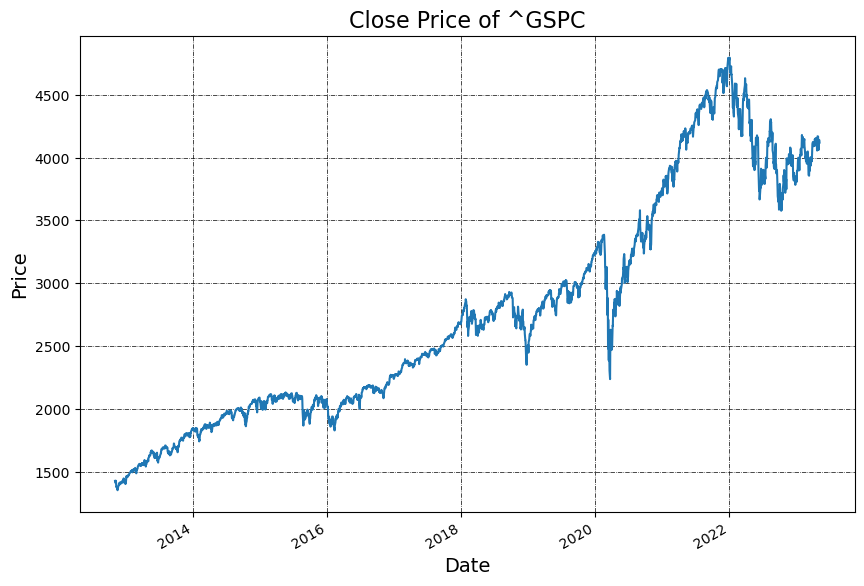

In [3]:
# Get the data for the Stock/Index
ticker = '^GSPC'  
stock_data = yf.download(ticker, start_date, end_date)
stock_data['daily_returns'] =  ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100

# Plot the adjusted close price
stock_data['Close'].plot(figsize=(10, 7))

plt.title("Close Price of {}".format(ticker), fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()

In [4]:
# Pre-processing the data
# Arrange the dataset to get the Daily Returns
stock_daily_returns = ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100
stock_returns = pd.DataFrame(stock_daily_returns)
stock_returns.columns = ['Return']
stock_returns = stock_returns.reset_index()

# Days where the stock market is open
tradingDays = pd.DataFrame(stock_returns['Date']).astype(str)
# Arrange index
stock_data["Date"] = stock_data.index
stock_data.reset_index(drop=True, inplace=True)

# get list of trading days so we can use .index()
listOfTradingDays = tradingDays.values.tolist()
# Helper functions to build the dataset
# Function to get 1-day's stock performance
def get1DayReturn(date):
    dayReturn = stock_returns.where(stock_returns['Date'] == date)
    dayReturn = dayReturn.dropna()
    return dayReturn['Return'].iloc[0]

# Function to get tommo's open
def getTommoOpen(date):
    indexOfTommoDay = listOfTradingDays.index([date]) + 1
    if indexOfTommoDay >= len(listOfTradingDays):
        return -1
    date2 = listOfTradingDays[indexOfTommoDay][0]
    return stock_data['Open'].where(stock_data['Date'] == date2).dropna().iloc[0]

def getStockDirection(date, n_day):
    dayOpen = getTommoOpen(date)
    indexOfDay = listOfTradingDays.index([date]) + n_day
    if indexOfDay >= len(listOfTradingDays):
        return -1
    dateClose = listOfTradingDays[indexOfDay][0]
    dayClose = stock_data['Close'].where(stock_data['Date'] == dateClose).dropna().iloc[0]
    if dayClose >= dayOpen:
        return 1
    else: 
        return 0
# Building the Stock prices Dataset
Stock_info = pd.DataFrame({'Today return' : [], 'Tommo_Open' : [], 'Tommo_Direction' : [], '2Day_Direction' : [], '3Day_Direction' : [], '4Day_Direction' : [], '5Day_Direction' : []})
for d in stock_data['Date']:
    Date = d
    date_s = str(d)[0:10]
    new_row = {'Today return': get1DayReturn(d), 'Tommo_Open' : getTommoOpen(date_s) , 'Tommo_Direction': getStockDirection(date_s, 1),'2Day_Direction' : getStockDirection(date_s, 2), '3Day_Direction': getStockDirection(date_s, 3),'4Day_Direction' : getStockDirection(date_s, 4), '5Day_Direction':getStockDirection(date_s, 5)}
    Stock_info = Stock_info.append(new_row, ignore_index=True)
# add this data to the stock_data dataframe
stock_data.drop(columns='daily_returns', inplace=True)
stock_data = pd.merge(stock_data, Stock_info, left_index=True, right_index=True)
stock_data.head()
# Pre-processing and cleaning
# Keep only trading days after 2021
stock_data = stock_data[stock_data['Date'] > specific_date]
stock_data = stock_data[stock_data['Date'] < specific_end_date]

# reset index
stock_data = stock_data.reset_index()
del stock_data['index']

# delete last row (since we always predict next day)
stock_data = stock_data.iloc[:-1]
# remove certain features
final_dataset = stock_data.drop(columns=['Date','Tommo_Direction','2Day_Direction', '3Day_Direction', '4Day_Direction', '5Day_Direction'])

In [6]:
# Load the preprocessed news data 
News_dataset = pd.read_feather("preprocessed_datasets/Test_2023_dataset.feather") 

# Load Vocab
with open('preprocessed_datasets/vocab_df_200_test.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [7]:
# remove the first day of news since we do not need it (we always predict from tommo open -> close)
News_dataset = News_dataset.drop(index=0)
# arrange index
News_dataset = News_dataset.reset_index()
del News_dataset['index']
News_dataset

,Date,tf_idf
0,2013-01-03,"[0.0, 0.0, 0.07219226694801421, 0.0, 0.0, 0.0,..."
1,2013-01-04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2013-01-07,"[0.0, 0.0, 0.02502410946465847, 0.175816470019..."
3,2013-01-08,"[0.0, 0.12537474426433934, 0.0, 0.0, 0.0713787..."
4,2013-01-09,"[0.0, 0.0, 0.0, 0.09458333509563867, 0.0, 0.0,..."
...,...,...
2593,2023-04-24,"[0.0, 0.0, 0.0, 0.17779064134043646, 0.0, 0.05..."
2594,2023-04-25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00907600..."
2595,2023-04-26,"[0.0, 0.0, 0.0, 0.06236315333086975, 0.0, 0.0,..."
2596,2023-04-27,"[0.14575526288464113, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [8]:
News_dataset['News Vector'] = News_dataset['tf_idf']

In [9]:
def Get_Keywords(date, vocab):
    # get news vector for the given date
    day_news = News_dataset.loc[News_dataset['Date'] == date]
    if day_news.empty:
        return -1
    
    vector = np.array(day_news['News Vector'].iloc[0].copy())
    
    top_terms = []
    i = 0
    # get top all terms from news vector with a non 0 tf.idf score
    while True:
        max_index = vector.argmax()
        if vector[max_index] == 0:
            return top_terms
        
        term = vocab[max_index]
        if term not in top_terms:
            top_terms.append((term,vector[max_index]))
        vector[max_index] = -1
        i = i + 1
    #print(top_terms)
    return top_terms

Get_Keywords('2023-03-13', vocab)

[('valley', 0.38707690504434994),
 ('silicon', 0.38707690504434994),
 ('black', 0.22662976001507473),
 ('bank', 0.1885290600869509),
 ('unit', 0.16997232001130608),
 ('system', 0.16997232001130608),
 ('make', 0.12902563501478329),
 ('collaps', 0.12902563501478329),
 ('come', 0.11331488000753737),
 ('entertain', 0.11331488000753737),
 ('countri', 0.11331488000753737),
 ('small', 0.11331488000753737),
 ('bet', 0.11331488000753737),
 ('fail', 0.11331488000753737),
 ('plan', 0.11331488000753737),
 ('jump', 0.11331488000753737),
 ('caus', 0.11331488000753737),
 ('tool', 0.11331488000753737),
 ('get', 0.09676922626108748),
 ('may', 0.07193088197391248),
 ('run', 0.06451281750739164),
 ('among', 0.06451281750739164),
 ('report', 0.06451281750739164),
 ('oil', 0.06451281750739164),
 ('back', 0.06451281750739164),
 ('nearli', 0.06451281750739164),
 ('crisi', 0.06451281750739164),
 ('messag', 0.06451281750739164),
 ('compani', 0.06284302002898362),
 ('student', 0.05665744000376868),
 ('fast', 0.

In [10]:
# Using just news vector
News_dataset['Label'] = stock_data['Tommo_Direction']

In [11]:
News_dataset

,Date,tf_idf,News Vector,Label
0,2013-01-03,"[0.0, 0.0, 0.07219226694801421, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.07219226694801421, 0.0, 0.0, 0.0,...",0.0
1,2013-01-04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,2013-01-07,"[0.0, 0.0, 0.02502410946465847, 0.175816470019...","[0.0, 0.0, 0.02502410946465847, 0.175816470019...",0.0
3,2013-01-08,"[0.0, 0.12537474426433934, 0.0, 0.0, 0.0713787...","[0.0, 0.12537474426433934, 0.0, 0.0, 0.0713787...",0.0
4,2013-01-09,"[0.0, 0.0, 0.0, 0.09458333509563867, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.09458333509563867, 0.0, 0.0,...",1.0
...,...,...,...,...
2593,2023-04-24,"[0.0, 0.0, 0.0, 0.17779064134043646, 0.0, 0.05...","[0.0, 0.0, 0.0, 0.17779064134043646, 0.0, 0.05...",1.0
2594,2023-04-25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00907600...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00907600...",0.0
2595,2023-04-26,"[0.0, 0.0, 0.0, 0.06236315333086975, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.06236315333086975, 0.0, 0.0,...",0.0
2596,2023-04-27,"[0.14575526288464113, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.14575526288464113, 0.0, 0.0, 0.0, 0.0, 0.0,...",1.0


In [12]:
weighted_vocabulary = {term: 0 for term in vocab}

In [13]:
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-05-01')

for day in pd.date_range(start=start_date, end=end_date, freq='D'):
    days_keywords = Get_Keywords(day.strftime('%Y-%m-%d'), vocab)
    if days_keywords != -1:
        for (term, w) in days_keywords:
            weighted_vocabulary[term] += w

In [14]:

def createWordCloud(weighted_vocabulary):
    # Create WordCloud object with weighted words
    wordcloud = WordCloud(background_color='white', width=1000, height=600).generate_from_frequencies(weighted_vocabulary)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


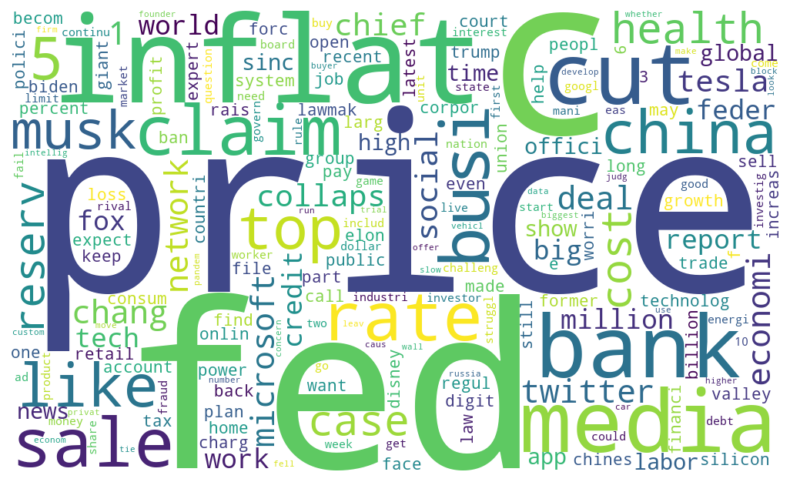

In [15]:
createWordCloud(weighted_vocabulary)